In [1]:
#import SQL library
import pyodbc
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.ticker as ticker
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [3]:
#pull RESELLER data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[RESELLER_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [4]:
dataset = pythonSQLobject

In [5]:
dataset.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,2024.994,Southeast
1,2011-05-31,6074.982,Southeast
2,2011-05-31,2024.994,Southeast
3,2011-05-31,2039.994,Southeast
4,2011-05-31,2039.994,Southeast


In [6]:
dataset.shape

(60919, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60919 entries, 0 to 60918
Data columns (total 3 columns):
OrderDate         60919 non-null datetime64[ns]
Revenue           60919 non-null float64
Territory_Name    60919 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


# There are several Territory in the Resealer revenue data, we start from time series analysis and forecasting for Australia Reseller.

In [8]:
dfa= dataset.loc[dataset['Territory_Name'] == 'Australia']

In [9]:
dfa.shape

(1713, 3)

In [10]:
dfa.sample()

,OrderDate,Revenue,Territory_Name
36607,2013-07-31,2860.884,Australia


In [11]:
dfa['OrderDate'].min(), dfa['OrderDate'].max()

(Timestamp('2013-05-30 00:00:00'), Timestamp('2014-05-01 00:00:00'))

In [12]:
dfa['OrderDate'] =  pd.to_datetime(dfa['OrderDate'], format='%Y/%m/%d')
dfa = dfa.sort_values(by=['OrderDate'], ascending=[True])
dfa.set_index('OrderDate', inplace=True) # Indexing with Time Series Data
print (dfa)

              Revenue Territory_Name
OrderDate                           
2013-05-30  2288.7072      Australia
2013-05-30  1204.6920      Australia
2013-05-30    27.6540      Australia
2013-05-30  2860.8840      Australia
2013-05-30   200.0520      Australia
...               ...            ...
2014-05-01   890.8200      Australia
2014-05-01   445.4100      Australia
2014-05-01    54.8940      Australia
2014-05-01  1430.4420      Australia
2014-05-01   125.9640      Australia

[1713 rows x 2 columns]


In [13]:
df=dfa.drop(["Territory_Name"],axis=1)

In [14]:
df.head()

,Revenue
OrderDate,
2013-05-30,2288.7072
2013-05-30,1204.6920
2013-05-30,27.6540
2013-05-30,2860.8840
2013-05-30,200.0520


In [15]:
y = df.resample('MS').sum()

In [16]:
y

,Revenue
OrderDate,
2013-05-01,49824.713775
2013-06-01,134280.982239
2013-07-01,266778.707809
2013-08-01,55341.462000
2013-09-01,124225.104000
2013-10-01,216979.992566
2013-11-01,63379.626000
2013-12-01,76501.650000
2014-01-01,200598.152976


In [17]:
# filling up by mean value
y = y.replace(0.000000, y['Revenue'].mean())

In [18]:
y

,Revenue
OrderDate,
2013-05-01,49824.713775
2013-06-01,134280.982239
2013-07-01,266778.707809
2013-08-01,55341.462000
2013-09-01,124225.104000
2013-10-01,216979.992566
2013-11-01,63379.626000
2013-12-01,76501.650000
2014-01-01,200598.152976


## Visualizing AUSTRALIA RESELLER Revenue Time Series Data

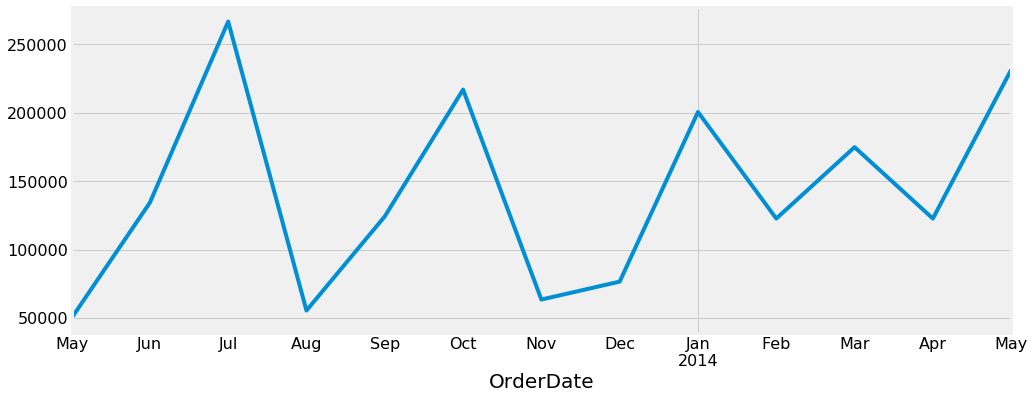

In [19]:
y["Revenue"].plot(figsize=(15, 6))
plt.show()

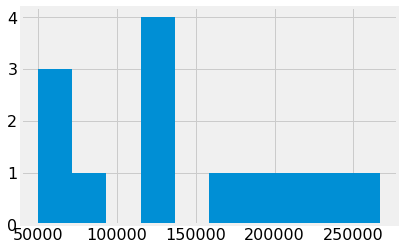

In [20]:
y["Revenue"].hist()

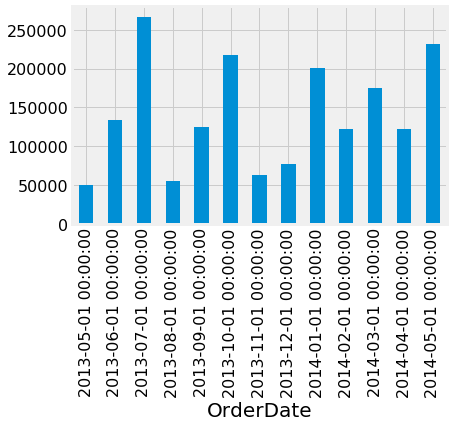

In [21]:
#
y.groupby('OrderDate')['Revenue'].mean().plot.bar()

# Time Series Modeling with Prophet
### Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running

In [22]:
AUR = dataset.loc[dataset['Territory_Name'] == 'Australia']
#dfa= dataset.loc[dataset['Territory_Name'] == 'Australia']
AUR.shape

(1713, 3)

In [23]:
AUR['OrderDate'] =  pd.to_datetime(AUR['OrderDate'], format='%Y/%m')
AUR = AUR.sort_values(by=['OrderDate'], ascending=[True])
AUR.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

AUR.drop(["Territory_Name"],axis=1, inplace=True)

In [24]:
y_AUR = AUR.resample('MS').sum()

In [25]:
# filling up by mean value
y_AUR = y_AUR['Revenue'].replace(0.000000, y_AUR['Revenue'].mean())

In [26]:
AUR = pd.DataFrame({'OrderDate': y_AUR.index, 'Revenue': y_AUR.values})

In [27]:
#store = AU.merge(SW,how='inner', on='OrderDate')
store1 = AUR
store1.rename(columns={'Revenue_x': 'AUR_revenue'}, inplace=True)
store1.head()

,OrderDate,Revenue
0,2013-05-01,49824.713775
1,2013-06-01,134280.982239
2,2013-07-01,266778.707809
3,2013-08-01,55341.462000
4,2013-09-01,124225.104000


# Fitt Model with Prophet

In [28]:

from fbprophet import Prophet
AUR = AUR.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
AUR_model = Prophet(interval_width=0.95)
AUR_model.fit(AUR)
AUR_forecast = AUR_model.make_future_dataframe(periods=60, freq='MS')
AUR_forecast = AUR_model.predict(AUR_forecast)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 9.


<Figure size 1296x432 with 0 Axes>

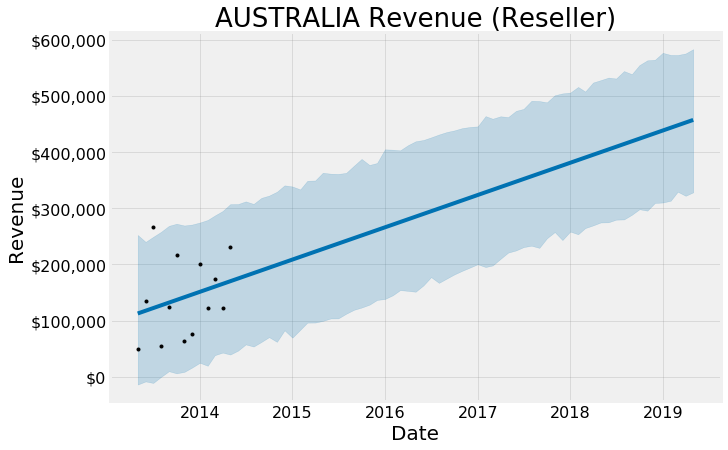

In [50]:
plt.figure(figsize=(18, 6))
AUR_model.plot(AUR_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('AUSTRALIA Revenue (Reseller)');

In [30]:
AUR_names = ['AUR_%s' % column for column in AUR_forecast.columns]

merge_AUR_forecast = AUR_forecast.copy()

merge_AUR_forecast.columns = AUR_names

forecast = merge_AUR_forecast
forecast = forecast.rename(columns={'AUR_ds': 'Date'})
forecast.head()

,Date,AUR_trend,AUR_yhat_lower,AUR_yhat_upper,AUR_trend_lower,AUR_trend_upper,AUR_additive_terms,AUR_additive_terms_lower,AUR_additive_terms_upper,AUR_multiplicative_terms,AUR_multiplicative_terms_lower,AUR_multiplicative_terms_upper,AUR_yhat
0,2013-05-01,112623.360081,-14021.346454,252526.317865,112623.360081,112623.360081,0.0,0.0,0.0,0.0,0.0,0.0,112623.360081
1,2013-06-01,117504.736798,-8470.119150,240208.551672,117504.736798,117504.736798,0.0,0.0,0.0,0.0,0.0,0.0,117504.736798
2,2013-07-01,122228.649747,-11175.762907,249199.803858,122228.649747,122228.649747,0.0,0.0,0.0,0.0,0.0,0.0,122228.649747
3,2013-08-01,127110.026455,-354.580162,258143.187014,127110.026455,127110.026455,0.0,0.0,0.0,0.0,0.0,0.0,127110.026455
4,2013-09-01,131991.403157,9761.430159,268788.644811,131991.403157,131991.403157,0.0,0.0,0.0,0.0,0.0,0.0,131991.403157


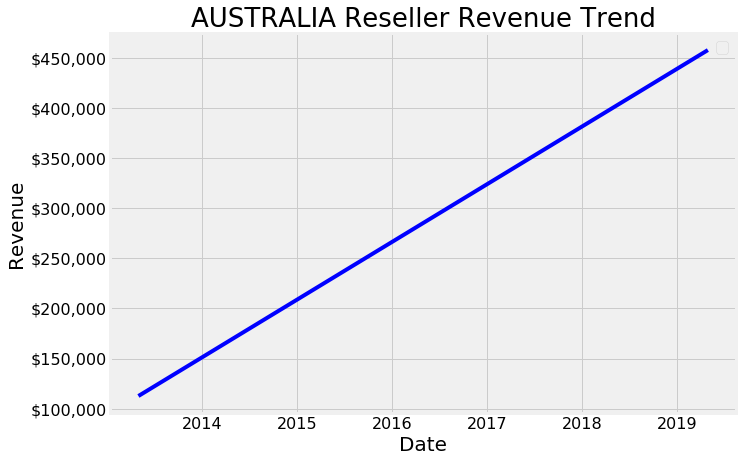

In [51]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['AUR_trend'], 'b-')
#plt.plot(forecast['Date'], forecast['SW_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('AUSTRALIA Reseller Revenue Trend');

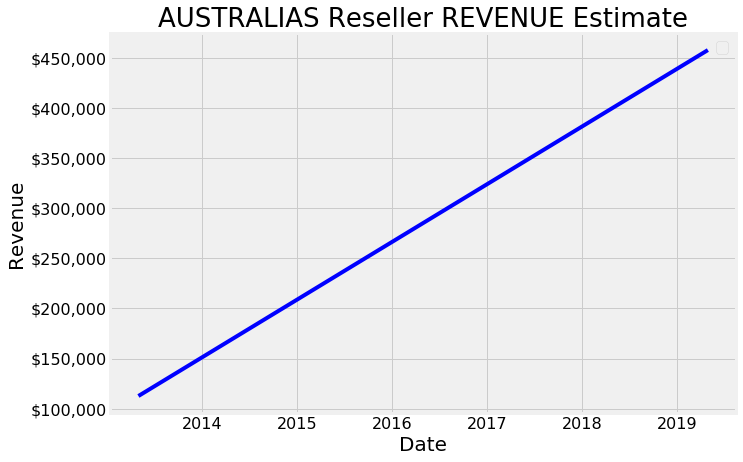

In [52]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['AUR_yhat'], 'b-')
#plt.plot(forecast['Date'], forecast['SW_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('AUSTRALIAS Reseller REVENUE Estimate');

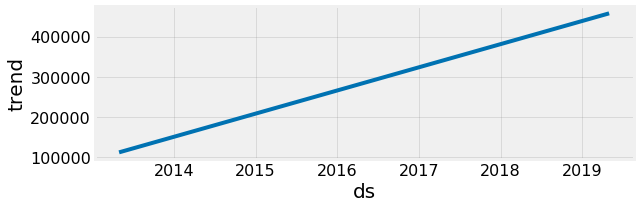

In [33]:
AUR_model.plot_components(AUR_forecast);

# Australia reseller does not have enough past data to forcast

# AUSTRALIA ONLINE 


In [34]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [35]:
#pull ONLINE data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[ONLINE_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [36]:
dataset1 = pythonSQLobject

In [37]:
dataset1.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,3578.2700,Canada
1,2011-05-31,3399.9900,France
2,2011-05-31,3399.9900,Northwest
3,2011-05-31,699.0982,Southwest
4,2011-05-31,3399.9900,Australia


In [38]:
dfo= dataset1.loc[dataset1['Territory_Name'] == 'Australia']

In [39]:
dfo.shape

(13345, 3)

In [40]:
dfo['OrderDate'].min(), dfo['OrderDate'].max()

(Timestamp('2011-05-31 00:00:00'), Timestamp('2014-06-30 00:00:00'))

# Data Preprocessing for AUSTRALIA ONLINE Revenue
## This step includes removing columns we do not need, check missing values, aggregate revenue by date and so on.

In [41]:
dfo['OrderDate'] =  pd.to_datetime(dfo['OrderDate'], format='%Y/%m/%d')
dfo = dfo.sort_values(by=['OrderDate'], ascending=[True])
dfo.set_index('OrderDate', inplace=True) # Indexing with Time Series Data
print (dfo)

            Revenue Territory_Name
OrderDate                         
2011-05-31  3399.99      Australia
2011-06-01  3578.27      Australia
2011-06-01  3374.99      Australia
2011-06-01  3399.99      Australia
2011-06-02  3578.27      Australia
...             ...            ...
2014-06-30    24.99      Australia
2014-06-30     3.99      Australia
2014-06-30   120.00      Australia
2014-06-30    35.00      Australia
2014-06-30     7.95      Australia

[13345 rows x 2 columns]


In [42]:
df1=dfo.drop(["Territory_Name"],axis=1)

In [43]:
df1.head()

,Revenue
OrderDate,
2011-05-31,3399.99
2011-06-01,3578.27
2011-06-01,3374.99
2011-06-01,3399.99
2011-06-02,3578.27


In [44]:
y1 = df1.resample('MS').sum()

In [45]:
y1

,Revenue
OrderDate,
2011-05-01,3399.9900
2011-06-01,206252.9146
2011-07-01,222538.2892
2011-08-01,177393.5028
2011-09-01,214593.3928
2011-10-01,217636.8228
2011-11-01,267232.2856
2011-12-01,223109.1074
2012-01-01,190022.3274


In [46]:
# filling up by mean value
y1 = y1.replace(0.000000, y1['Revenue'].mean())

In [47]:
y1

,Revenue
OrderDate,
2011-05-01,3399.9900
2011-06-01,206252.9146
2011-07-01,222538.2892
2011-08-01,177393.5028
2011-09-01,214593.3928
2011-10-01,217636.8228
2011-11-01,267232.2856
2011-12-01,223109.1074
2012-01-01,190022.3274


# Have a quick peek 2014 furniture sales data.

In [48]:
y1['2014':]

,Revenue
OrderDate,
2014-01-01,435025.32
2014-02-01,355170.42
2014-03-01,468617.58
2014-04-01,413116.58
2014-05-01,479766.61
2014-06-01,9012.50


# Visualizing Australia Online revenue Time Series Data

TypeError: float() argument must be a string or a number, not 'Period'

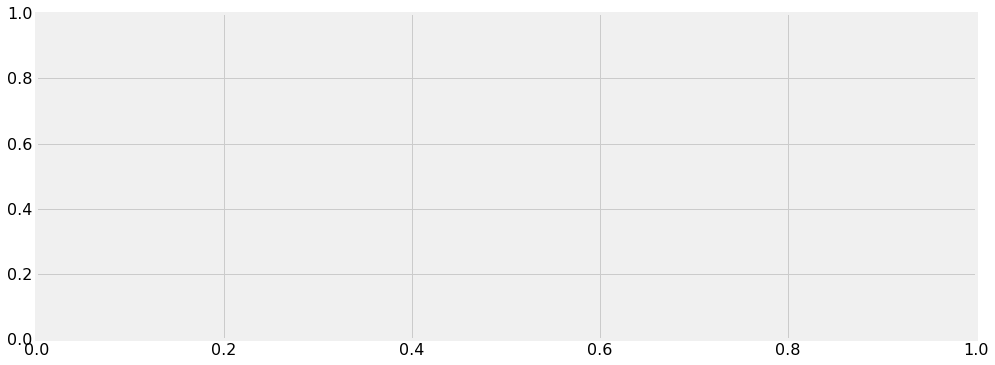

In [49]:
y1["Revenue"].plot(figsize=(15, 6))
plt.show()

# As we can see, Australia's Online data was extracted middle of June 2014, so lets drop the month from our data 

In [53]:
y1 = y1.drop(y1.index[len(y1)-1])

In [55]:
y1

,Revenue
OrderDate,
2011-05-01,3399.9900
2011-06-01,206252.9146
2011-07-01,222538.2892
2011-08-01,177393.5028
2011-09-01,214593.3928
2011-10-01,217636.8228
2011-11-01,267232.2856
2011-12-01,223109.1074
2012-01-01,190022.3274


# Methods to Check Stationarity


#### Case 1: Both tests conclude that the series is not stationary -> series is not stationary¶
#### Case 2: Both tests conclude that the series is stationary -> series is stationary
#### Case 3: KPSS = stationary and ADF = not stationary -> trend stationary, remove the trend to make series strict stationary(Differencing removes the trend present in the series)
#### Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary(log transformation is for handling high variance in the series)

# ADF (Augmented Dickey Fuller) Test

In [56]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(y1["Revenue"])

Results of Dickey-Fuller Test:
Test Statistic                  0.033034
p-value                         0.961180
#Lags Used                      1.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


The statistics shows that the time series is not stationary as Test Statistic > Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data stationary. For doing so, we will differencing from the data.

# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

In [57]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)


kpss_test(y1["Revenue"])

Results of KPSS Test:
Test Statistic            0.382554
p-value                   0.084675
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


# Sessionality and  Removing Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

We will take rolling average here to remove the trend. We will take the window size of 1 based on the fact that each month has 30 days.

TypeError: float() argument must be a string or a number, not 'Period'

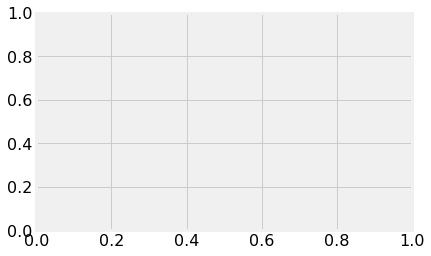

In [58]:
y1_diff = y1["Revenue"]-y1["Revenue"].shift()
y1_diff.dropna().plot()

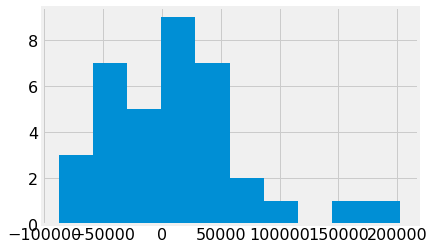

In [60]:
y1_diff.hist()

## Seasonal Differencing¶
In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

yt‘ = yt – y(t-n)

TypeError: float() argument must be a string or a number, not 'Period'

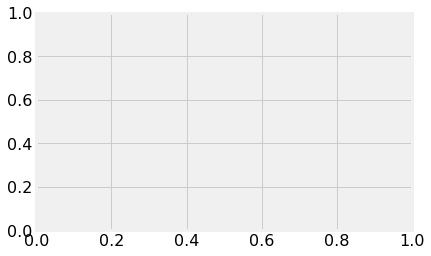

In [61]:
n=3
y1['y1_diff'] = y1['Revenue'] - y1['Revenue'].shift(n)
y1['y1_diff'].dropna(inplace=True)
y1['y1_diff'].plot()

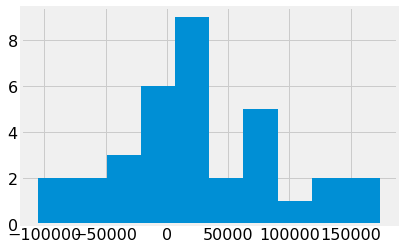

In [62]:
y1['y1_diff'].hist()

In [63]:
adf_test(y1['y1_diff'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.101435
p-value                         0.714499
#Lags Used                     10.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


In [64]:
kpss_test(y1['y1_diff'])

Results of KPSS Test:
Test Statistic            0.223245
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



# Transformation
Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. Let’s do a quick log transform and differencing on our air passenger dataset:

In [65]:
y1['y1_log'] = np.log(y1['y1_diff'])
y1['y1_log'].dropna(inplace=True)

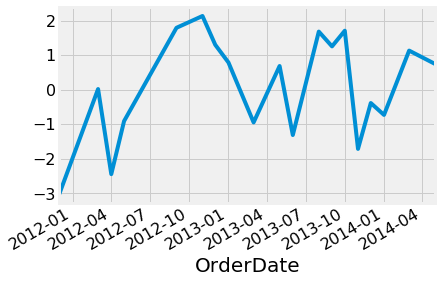

In [66]:
y1['y1_log_shift'] = y1['y1_log'] - y1['y1_log'].shift(3)
y1['y1_log_shift'].dropna(inplace=True)
y1['y1_log_shift'].plot()

In [67]:
y1['y1_log_shift']

OrderDate
2011-12-01   -3.017105
2012-03-01    0.018768
2012-04-01   -2.442534
2012-05-01   -0.909006
2012-09-01    1.789263
2012-11-01    2.130535
2012-12-01    1.297850
2013-01-01    0.785724
2013-03-01   -0.946390
2013-05-01    0.684346
2013-06-01   -1.311677
2013-08-01    1.679259
2013-09-01    1.252374
2013-10-01    1.704712
2013-11-01   -1.711719
2013-12-01   -0.385472
2014-01-01   -0.729628
2014-03-01    1.129716
2014-05-01    0.743073
Name: y1_log_shift, dtype: float64

In [68]:
y1['y1_log']

OrderDate
2011-05-01          NaN
2011-06-01          NaN
2011-07-01          NaN
2011-08-01    12.066773
2011-09-01     9.028876
2011-10-01          NaN
2011-11-01    11.405772
2011-12-01     9.049669
2012-01-01          NaN
2012-02-01          NaN
2012-03-01     9.047644
2012-04-01     8.963238
2012-05-01     8.140663
2012-06-01          NaN
2012-07-01          NaN
2012-08-01          NaN
2012-09-01    10.836907
2012-10-01          NaN
2012-11-01    11.093773
2012-12-01     9.438513
2013-01-01    11.622631
2013-02-01          NaN
2013-03-01    10.147384
2013-04-01          NaN
2013-05-01    10.122858
2013-06-01    10.310954
2013-07-01          NaN
2013-08-01    11.826643
2013-09-01    11.375232
2013-10-01    12.015666
2013-11-01    10.114923
2013-12-01    10.989760
2014-01-01    11.286038
2014-02-01          NaN
2014-03-01    11.244639
2014-04-01          NaN
2014-05-01    11.732833
Freq: MS, Name: y1_log, dtype: float64

In [69]:
adf_test(y1['y1_log_shift'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.989464
p-value                         0.001467
#Lags Used                      2.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64


In [70]:
kpss_test(y1['y1_log_shift'])

Results of KPSS Test:
Test Statistic           0.274617
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

Differencing can help to make the series stable and eliminate the trend.

#### We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

TypeError: float() argument must be a string or a number, not 'Period'

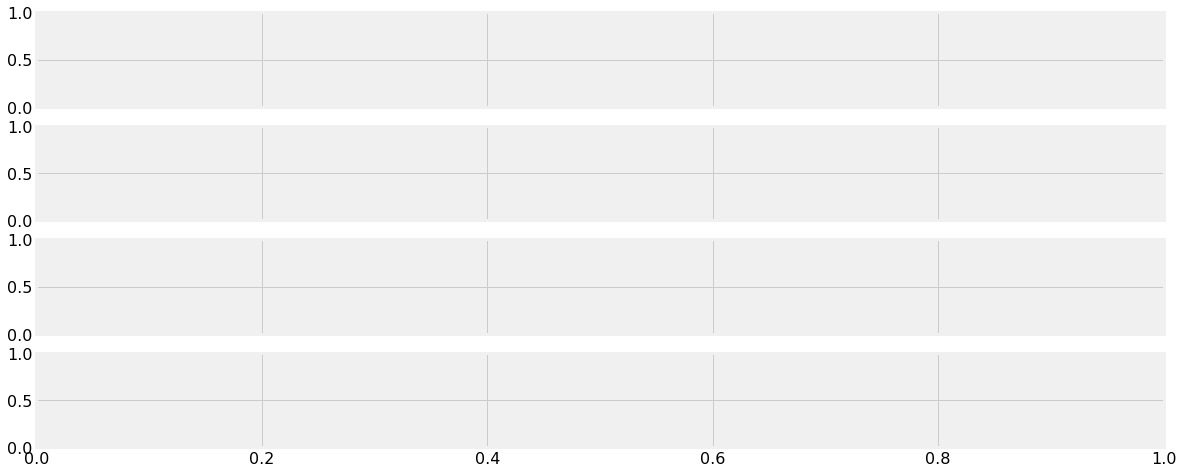

In [71]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y1['Revenue'], model='additive')
fig = decomposition.plot()
plt.show()

# Time series forecasting with ARIMA¶
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [73]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [74]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y1['y1_log_shift'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results1 = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results1.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:63.80209503463807
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:22.82807648651493
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:26.070939002611453
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:62.716876703237084
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:20.30136292338936
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:28.000126612567087
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:69.54042595545548
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:20.856140682374786
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:25.138950952085523
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:60.758878971409615
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:19.493753447047883
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:26.864924796389072
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:65.3346191461419
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:22.35150682218422
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:21.65170300890172
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:65.38338107426586
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:22.168690843003553
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:28.271916573783646
A

The above output suggests that SARIMAX(1, 1, 1)x(1, 0, 0, 12) yields the lowest AIC value of 290.81. Therefore we should consider this to be optimal option.

# Fitting the ARIMA model

In [75]:
mod = sm.tsa.statespace.SARIMAX(y1['Revenue'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 0 , 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1 = mod.fit()
print(results1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7461      0.414     -1.802      0.072      -1.558       0.066
ma.L1          0.2224      0.560      0.397      0.691      -0.875       1.319
ar.S.L12       0.0492      0.253      0.195      0.846      -0.446       0.545
sigma2      1.878e+09   4.31e-11   4.36e+19      0.000    1.88e+09    1.88e+09


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

# We should always run model diagnostics to investigate any unusual behavior.

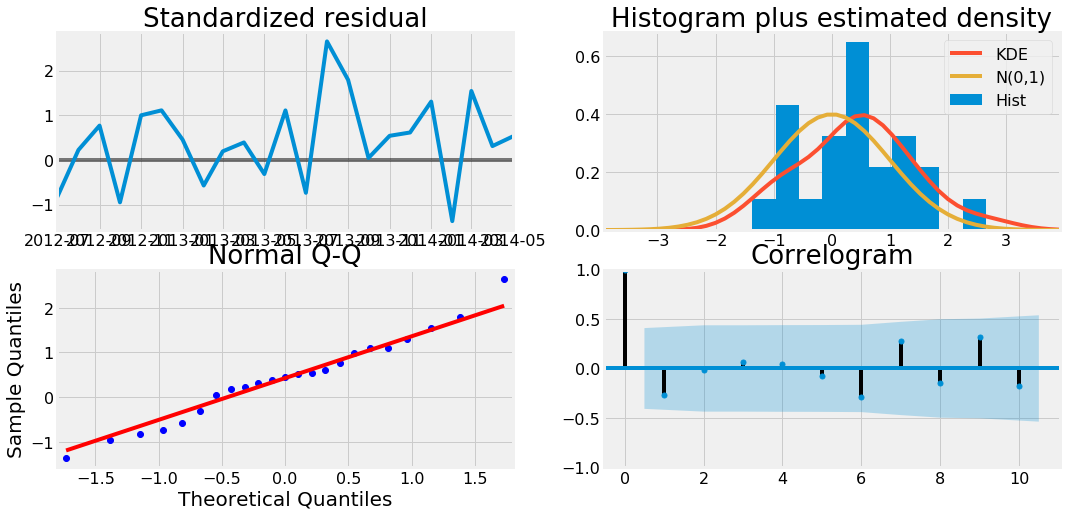

In [76]:
results1.plot_diagnostics(figsize=(16, 8))
plt.show()

TypeError: float() argument must be a string or a number, not 'Period'

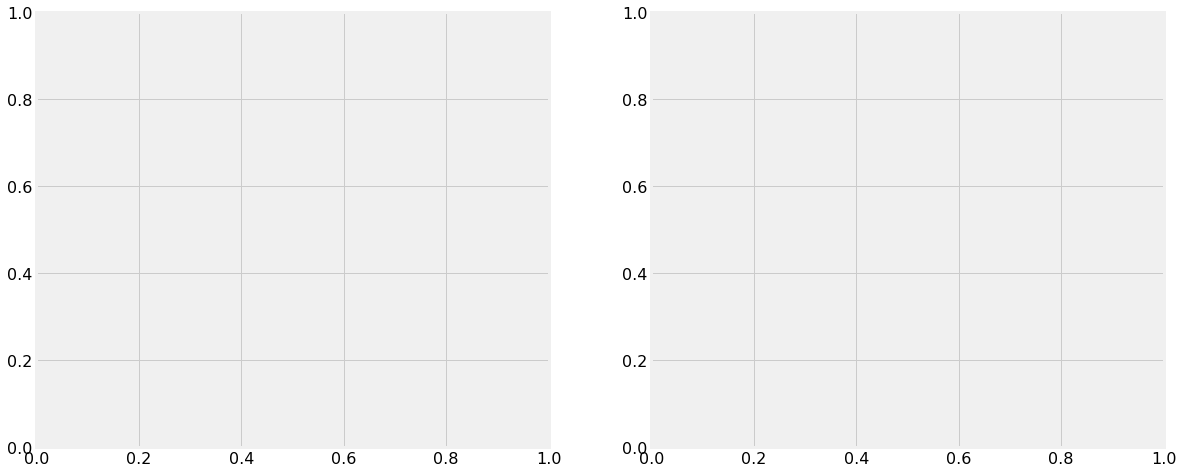

In [77]:
# Plot residual errors
residuals1 = pd.DataFrame(results1.resid)
fig, ax = plt.subplots(1,2)
residuals1.plot(title="Residuals", ax=ax[0])
residuals1.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Validating forecasts

TypeError: float() argument must be a string or a number, not 'Period'

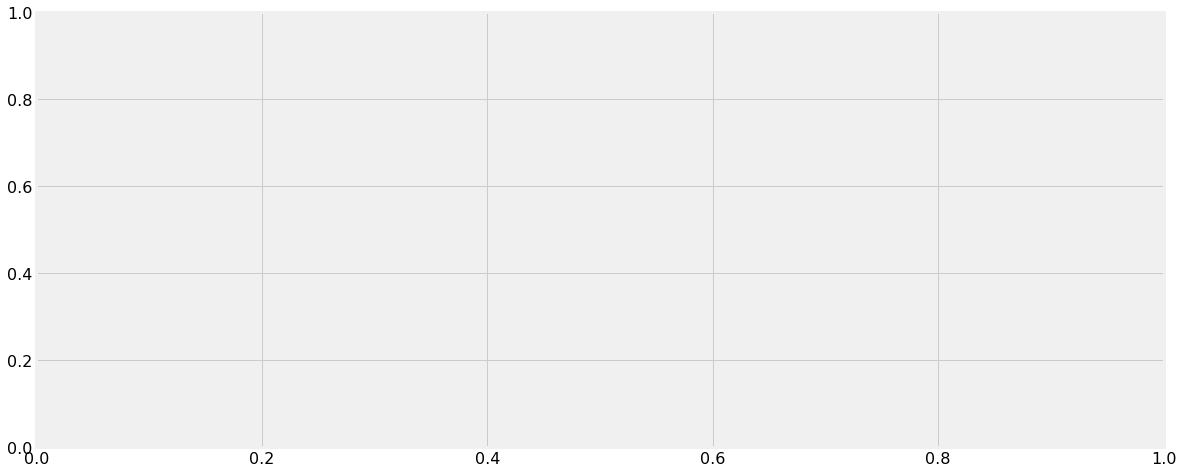

In [78]:
pred = results1.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y1["Revenue"].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()


The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [79]:
y_forecasted1 = pred.predicted_mean
y_truth1= y1["Revenue"]['2014-01-01':]
# Compute the mean square error
mse1 = ((y_forecasted1 - y_truth1) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse1, 2)))

The Mean Squared Error of our forecasts is 2378707126.27


## The Mean Squared Error of our forecasts is 0.11

In [80]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse1), 2)))

The Root Mean Squared Error of our forecasts is 48771.99


## The Root Mean Squared Error of our forecasts is 0.33
In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit. Root Mean Square Error (RMSE) tells us that our model was able to forecast the average monthly GB revenue in the test set within 258.06 of the real revenue. Our GB monthly revenue range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

# Producing and visualizing forecasts for Australia Online

TypeError: float() argument must be a string or a number, not 'Period'

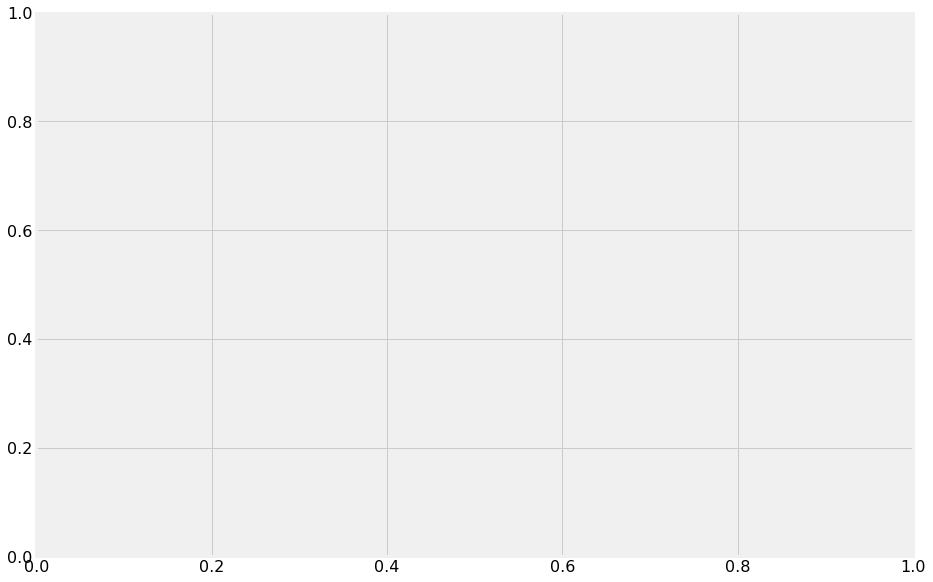

In [81]:
pred_uc1 = results1.get_forecast(steps=60)
pred_ci1= pred_uc1.conf_int()
ax = y1["Revenue"].plot(label='observed', figsize=(14, 10))
#pred_uc1.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 1],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

 ### Australia's revenue forcast is high rock

# Time Series Modeling with Prophet
## Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running

In [82]:
AU = dataset1.loc[dataset1['Territory_Name'] == 'Australia']
AU.shape

(13345, 3)

In [83]:
AU['OrderDate'] =  pd.to_datetime(AU['OrderDate'], format='%Y/%m')
AU = AU.sort_values(by=['OrderDate'], ascending=[True])
AU.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

AU.drop(["Territory_Name"],axis=1, inplace=True)

In [84]:
#y = df.resample('MS').mean()
y_AU = AU.resample('MS').sum()


In [85]:
# filling up by mean value
y_AU = y_AU['Revenue'].replace(0.000000, y_AU['Revenue'].mean())

In [86]:
AU = pd.DataFrame({'OrderDate': y_AU.index, 'Revenue': y_AU.values})

In [87]:
#store = AU.merge(SW,how='inner', on='OrderDate')
store = AU
store.rename(columns={'Revenue_x': 'AU_revenue'}, inplace=True)
store.head()

,OrderDate,Revenue
0,2011-05-01,3399.9900
1,2011-06-01,206252.9146
2,2011-07-01,222538.2892
3,2011-08-01,177393.5028
4,2011-09-01,214593.3928


In [88]:
plt.figure(figsize=(20, 8))
plt.plot(store['OrderDate'], store['AU_revenue'], 'b-', label = 'AU')
#plt.plot(store['OrderDate'], store['SW_revenue'], 'r-', label = 'SW')
plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Revenue of AUSTRALIA Reseller')
plt.legend();

KeyError: 'AU_revenue'

<Figure size 1440x576 with 0 Axes>

# Fitt Model with Prophet

In [ ]:
from fbprophet import Prophet
AU = AU.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
AU_model = Prophet(interval_width=0.95)
AU_model.fit(AU)
AU_forecast = AU_model.make_future_dataframe(periods=60, freq='MS')
AU_forecast = AU_model.predict(AU_forecast)

In [ ]:
plt.figure(figsize=(18, 6))
AU_model.plot(AU_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.title('AUSTRALIA Revenue (Online)');

# Trend and Forecast Visualization

In [ ]:
AU_names = ['AU_%s' % column for column in AU_forecast.columns]

merge_AU_forecast = AU_forecast.copy()

merge_AU_forecast.columns = AU_names

forecast = merge_AU_forecast
forecast = forecast.rename(columns={'AU_ds': 'Date'})
forecast.head()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['AU_trend'], 'b-')
#plt.plot(forecast['Date'], forecast['SW_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.title('AUSTRALIA Reseller Revenue Trend');

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['AU_yhat'], 'b-')
#plt.plot(forecast['Date'], forecast['SW_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.title('AUSTRALIAS Reseller REVENUE Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two Teritory in the data.

In [ ]:
AU_model.plot_components(AU_forecast);

### Good to see that the revenue for  Australia Online have been linearly increasing over time and will be keep growing.